## Trig Function

#### Libs

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

# LaTeX and font settings for publication-quality plots
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

#### Function

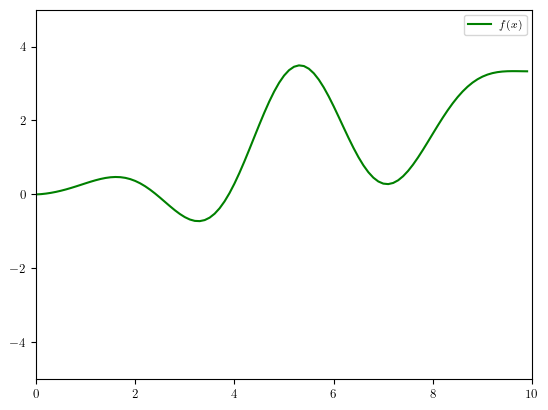

In [2]:
# This is the true unknown function we are trying to approximate
f = lambda x: (x**0.5*(np.sin(1.5 * x) * np.exp(-((x - 5) ** 2) / 10) + 0.1 * x)).flatten()
x = np.arange(0, 10, 0.1)

plt.plot(x, f(x), 'g', label=r'$f(x)$')
plt.axis([0, 10, -5, 5])
plt.legend()
plt.show()

#### Kernel

In [3]:
# Matern kernel with nu=2.5
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.spatial.distance import cdist

In [4]:
# RBF
def RBF(a, b):
    kernelParameter_l = 0.1
    kernelParameter_sigma = 1.0
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return kernelParameter_sigma*np.exp(-.5 * (1/kernelParameter_l) * sqdist)

# Matern kernel with nu=2.5
def matern52(a, b, length_scale=1.0, sigma=1.0):
    # Compute pairwise distances
    d = cdist(a / length_scale, b / length_scale, metric='euclidean')
    
    # Matern 5/2 formula
    sqrt5 = np.sqrt(5)
    term = sqrt5 * d
    kernel_matrix = sigma**2 * (1 + term + (term**2)/3) * np.exp(-term)
    
    return kernel_matrix

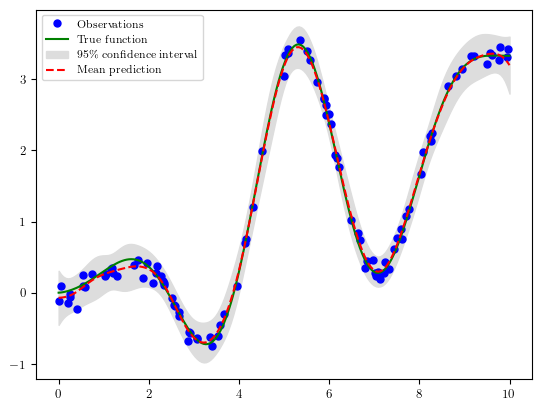

In [16]:
# Sample some input points and noisy versions of the function evaluated at
# these points. 
N = 100         # number of existing observation points (training points).
n = 200        # number of test points.
s = 0.1    # noise variance.

X = np.random.uniform(0, 10, size=(N,1))     # N training points 
y = f(X) + s*np.random.randn(N)

K = matern52(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))     # line 1 

# points we're going to make predictions at.
Xtest = np.linspace(0, 10, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, matern52(X, Xtest))   # k_star = kernel(X, Xtest), calculating v := l\k_star
mu = np.dot(Lk.T, np.linalg.solve(L, y))    # \alpha = np.linalg.solve(L, y) 

# compute the variance at our test points.
K_ = matern52(Xtest, Xtest)                  # k(x_star, x_star)        
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)   
s = np.sqrt(s2)

# PLOTS:
plt.figure(1)
plt.clf()
plt.plot(X, y, 'bo', ms=5, lw=2, label='Observations')
plt.plot(Xtest, f(Xtest), 'g-', label='True function')
plt.gca().fill_between(Xtest.flat, mu-2*s, mu+2*s, color="#dddddd", label=r'$95\%$ confidence interval')
plt.plot(Xtest, mu, 'r--', label='Mean prediction')
#plt.savefig('predictive.png', bbox_inches='tight', dpi=300)
#plt.title('Mean predictions plus 2 st.deviations')
#plt.axis([-5, 5, -3, 3])
plt.legend()
#plt.savefig('5obs.pdf', bbox_inches='tight', dpi=300)
plt.show()

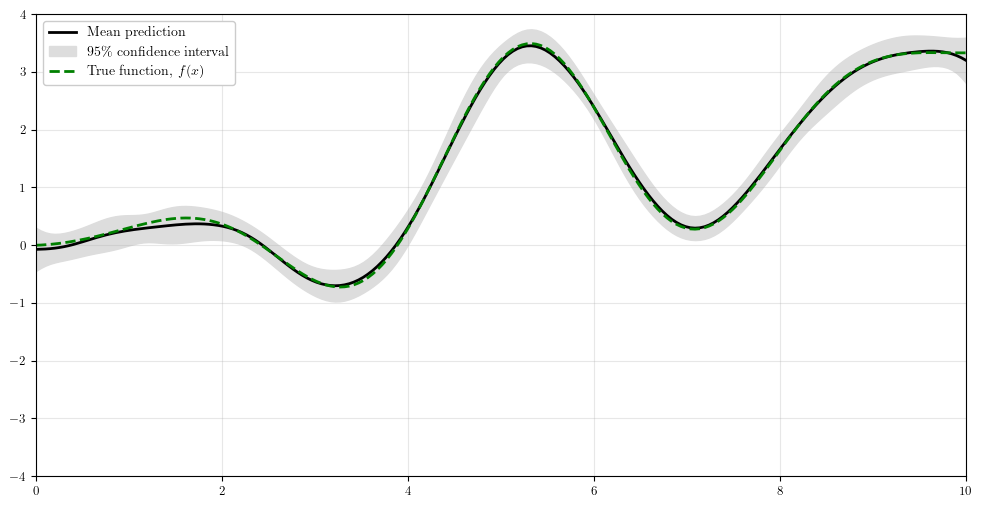

In [17]:
# draw samples from the posterior at our test points.

L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))  # size=(n, m), m shown how many posterior  

# Set up colors for posterior samples (using a colormap)
#sample_colors = plt.cm.viridis(np.linspace(0, 1, f_post.shape[1]))  # 5 distinct colors

plt.figure(figsize=(12,6))

# Main plots
#plt.plot(X, y, 'k+', markersize=12, markeredgewidth=2, label='Observations')
plt.plot(Xtest, mu, 'k-', linewidth=2, label='Mean prediction')
plt.gca().fill_between(Xtest.flat, mu-1.96*s, mu+1.96*s, color="#dddddd", label=r'95\% confidence interval')
plt.plot(Xtest, f(Xtest), 'g--', linewidth=2, label=r'True function, $f(x)$')

# Plot posterior samples with individual colors
#for i in range(f_post.shape[1]):
#    plt.plot(Xtest, f_post[:,i], linewidth=0.8, 
#             #color=sample_colors[i], 
#             alpha=0.7)
#             #label=f'Posterior sample {i+1}')

plt.axis([0, 10, -4, 4])
plt.legend(loc='upper left', framealpha=1, fontsize=10)
#plt.title('GP Posterior Samples with Color Coding', pad=20)
plt.grid(alpha=0.3)
plt.savefig('5obs.pdf', bbox_inches='tight', dpi=600)
plt.show()